Merton Model incorporates jumps in stock prices by assuming that drift is not constant and it follows some jump process based on poisson distribution. Basically, under Merton model, randomness is incorporated due to 3 reason: - 

1. Undertying stock process
2. Size of the jump
3. Timing of jump

1 and 2 follows standard normal while 3 follows Poisson distribution

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss

$$
\begin{equation*}
    dS_t = \left( r - r_j \right) S_t dt + \sigma S_t dZ_t + J_t S_t dN_t
\end{equation*}
$$

with the following discretized form:

$$
\begin{equation*}
    S_t = S_{t-1} \left( e^{\left(r-r_j-\frac{\sigma^2}{2}\right)dt + \sigma \sqrt{dt} z_t^1}+
    \left(e^{\mu_j+\delta z_t^2}-1 \right) y_t \right)
\end{equation*}
$$

where $z_t^1$ and $z_t^2$ follow a standard normal and $y_t$ follows a Poisson process. Finally, $r_j$ equals to:

$$
\begin{equation*}
r_j = \lambda \left(e^{\mu_j+\frac{\delta^2}{2}}\right)-1
\end{equation*}
$$

Note that r_j is the term which make sure that the process is risk neutral even after the jump in drift

In [2]:
# as of now, we are assuming these paramters but in the next course, we will learn about how to calibrate these parameters
lamb = 0.75  # Lambda of the model
mu = -0.6  # Mu
delta = 0.25  # Delta

In [3]:
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
T = 1.0  # Maturity/time period (in years)
S0 = 100  # Current Stock Price

Ite = 10000  # Number of simulations (paths)
M = 50  # Number of steps
dt = T / M  # Time-step

In [4]:
SM = np.zeros((M + 1, Ite))
SM[0] = S0

# rj
rj = lamb * (np.exp(mu + 0.5 * delta**2) - 1)

# Random numbers
z1 = np.random.standard_normal((M + 1, Ite))
z2 = np.random.standard_normal((M + 1, Ite))
y = np.random.poisson(lamb * dt, (M + 1, Ite))

In [13]:
for t in range(1, M + 1):
    SM[t] = SM[t - 1] * (
        np.exp((r - rj - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z1[t])
        + (np.exp(mu + delta * z2[t]) - 1) * y[t]
    )
    SM[t] = np.maximum(
        SM[t], 0.00001
    )

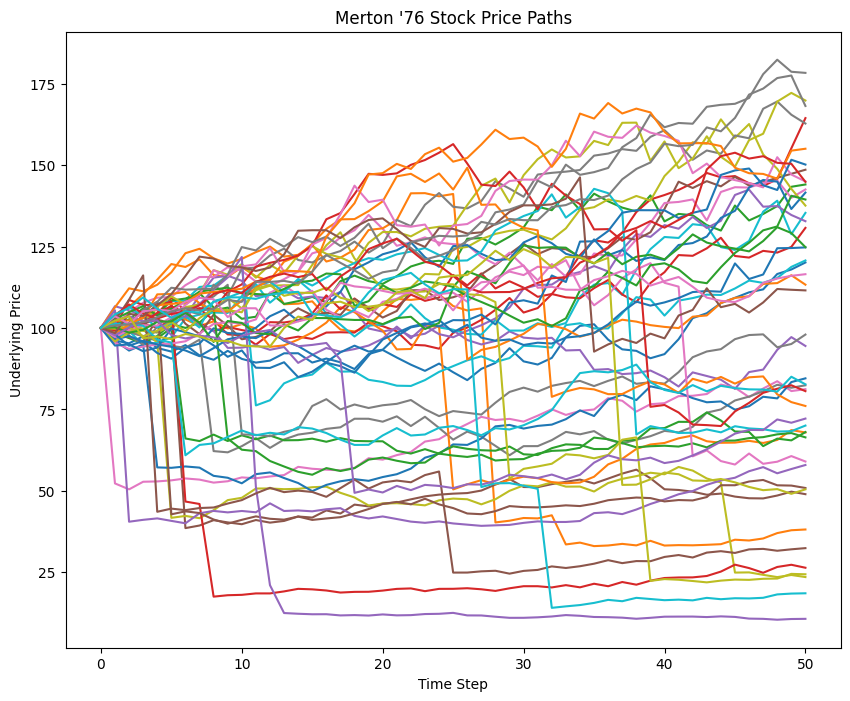

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(SM[:, 100:150])
plt.title("Merton '76 Stock Price Paths")
plt.xlabel("Time Step")
plt.ylabel("Underlying Price")
plt.show()

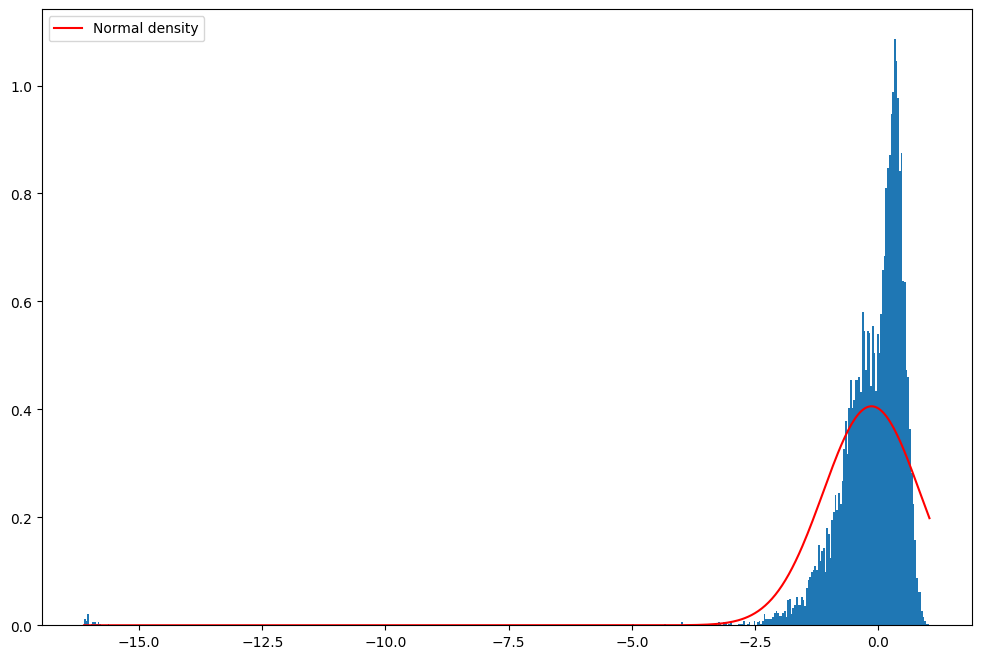

In [15]:
retSM = np.log(SM[-1, :] / S0)
x = np.linspace(retSM.min(), retSM.max(), 500)

plt.figure(figsize=(12, 8))
plt.hist(retSM, density=True, bins=500)
plt.plot(
    x, ss.norm.pdf(x, retSM.mean(), retSM.std()), color="r", label="Normal density"
)
plt.legend()
plt.show()

In [16]:
def merton_call_mc(S, K, r, T, t):
    payoff = np.maximum(0, S[-1, :] - K)

    average = np.mean(payoff)

    return np.exp(-r * (T - t)) * average

In [17]:
print("European Call Price under Merton: ", merton_call_mc(SM, 90, r, T, 0))

European Call Price under Merton:  27.537654367131687


### Changing Merton Model Parameters

In [30]:
lamb = 0.99  # Increased Lambda of the model meaning increasing the probability of the jumps to 99%
mu = -0.6  # Mu
delta = 0.1  # Delta

r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
T = 1.0  # Maturity/time period (in years)
S0 = 100  # Current Stock Price

Ite = 10000  # Number of simulations (paths)
M = 50  # Number of steps
dt = T / M  # Time-step

SM = np.zeros((M + 1, Ite))
SM[0] = S0

# rj
rj = lamb * (np.exp(mu + 0.5 * delta**2) - 1)

# Random numbers
z1 = np.random.standard_normal((M + 1, Ite))
z2 = np.random.standard_normal((M + 1, Ite))
y = np.random.poisson(lamb * dt, (M + 1, Ite))

In [31]:
for t in range(1, M + 1):
    SM[t] = SM[t - 1] * (
        np.exp((r - rj - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z1[t])
        + (np.exp(mu + delta * z2[t]) - 1) * y[t]
    )
    SM[t] = np.maximum(
        SM[t], 0.00001
    )  # To ensure that the price never goes below zero!

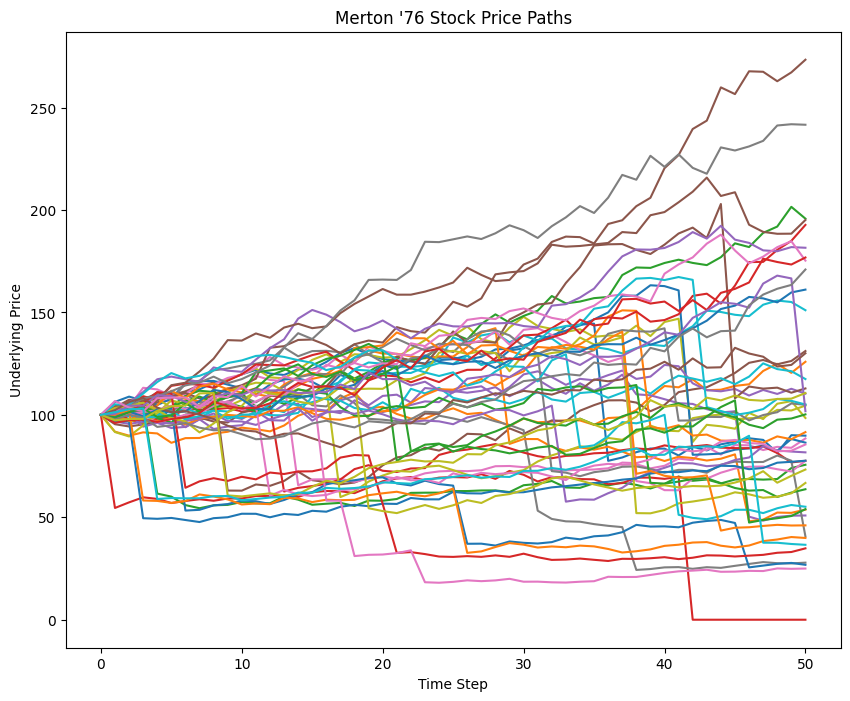

In [32]:
plt.figure(figsize=(10, 8))
plt.plot(SM[:, 100:150])
plt.title("Merton '76 Stock Price Paths")
plt.xlabel("Time Step")
plt.ylabel("Underlying Price")
plt.show()

More extreme left distirbution because of more and more negative jumps, if we change the sign of jumps (mu) to positive, the distirbution of returns will be skewed towards positive side.